# BERT 모델 증류

# 1. 초기화 및 데이터 로딩

## 1.1 초기화

In [1]:
import re
import string
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, jaccard_score
from datasets import Dataset
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, EvalPrediction, AutoModelForSequenceClassification, AutoTokenizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_text(text):
    # 인쇄할 수 없는 문자 제거
    text = ''.join(filter(lambda x: x in string.printable, text))
    # 여러 개의 공백 문자를 하나의 공백으로 바꾸기
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text.strip()

# WITH NO GENRES
def get_anime_description(anime_row):
    """
    입력 데이터의 다양한 기능을 기반으로 애니메이션 제목에 대한 사용자 지정 설명을 생성합니다.

    :param anime_row: 관련 애니메이션 정보가 포함된 MyAnimeList 데이터 세트의 행입니다.
    :return: 애니메이션에 대한 사용자 지정 설명이 포함된 형식화된 문자열입니다.
    """

    # 애니메이션 유형(TV 프로그램 또는 기타) 결정하기
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # 입력 데이터의 관련 기능을 사용하여 형식이 지정된 설명을 작성합니다.
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}."
    )

    return clean_text(description)

def preprocess_data(examples, text_col):
    one_hot_encoded_matrix = []
    text = examples[text_col]
    genres = examples["Genres"]
    for genre in genres:
        g = genre.split(', ')
        one_hot_encoded_row = [1 if label in g else 0 for label in unique_labels]
        one_hot_encoded_matrix.append(one_hot_encoded_row)

    # one_hot_encoded_matrix를 LongTensor로 변환합니다.
    one_hot_encoded_matrix = [torch.tensor(o, dtype=torch.float32) for o in one_hot_encoded_matrix]

    # 텍스트 인코딩
    encoding = tokenizer(text, truncation=True, max_length=256)
    
    # 레이블 추가
    encoding["labels"] = one_hot_encoded_matrix

    return encoding

## 1.2 데이터 로딩 및 전처리

In [4]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv')
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [5]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [6]:
# 병합된 애니메이션 데이터 프레임에 새 설명을 위한 새 열을 만듭니다.
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)

In [7]:
all_genres = list(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))
all_genres[:3]

['Action', 'Adventure', 'Comedy']

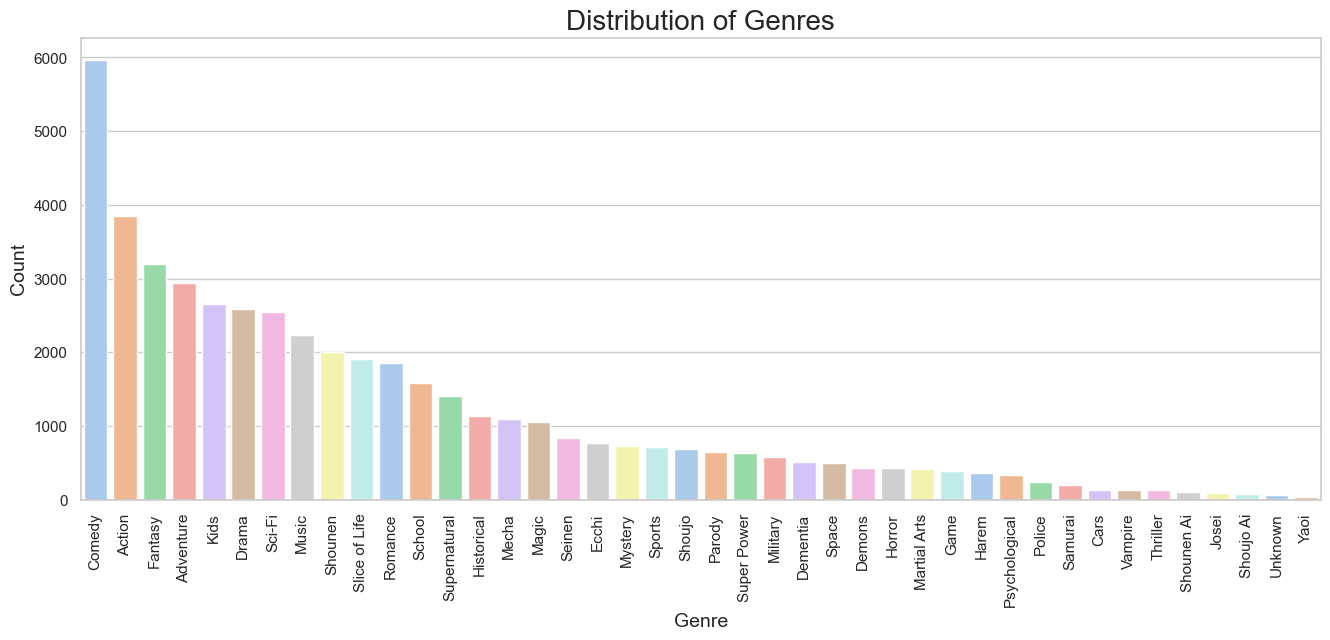

In [8]:
sns.set_style('whitegrid')
sns.set_context('notebook')

# Prepare the data
genre_counts = pd.Series(all_genres).value_counts()

# Create the plot
plt.figure(figsize=(16, 6))

colors = sns.color_palette('pastel')[0:len(genre_counts)]
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)

plt.title('Distribution of Genres', fontsize=20)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)

# Show and save the plot
plt.show()

In [9]:
unique_labels = sorted(list(set(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))))
print(len(unique_labels), unique_labels)

42 ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi']


In [10]:
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

In [11]:
anime_with_synopsis_dataset = Dataset.from_pandas(pre_merged_anime[['synopsis', 'Genres', 'generated_description']])
anime_with_synopsis_dataset = anime_with_synopsis_dataset.train_test_split(test_size=.2, seed=42)

# 2. 모델 증류

## 2.1 관련 함수 정의

이 코드는 다중 레이블 분류 문제에서 예측 결과와 실제 레이블을 비교하여 여러 가지 평가 지표를 계산하는 함수입니다. 함수의 동작을 단계별로 설명하겠습니다:

1. 함수는 `predictions`(예측 값), `labels`(실제 레이블), 그리고 선택적으로 `threshold`(임계값, 기본값은 0.5)를 입력으로 받습니다.

2. `torch.nn.Sigmoid()` 함수를 초기화하여 예측 값을 변환하는 데 사용할 시그모이드 함수를 정의합니다.

3. `probs = sigmoid(torch.Tensor(predictions))`를 사용하여 예측 값에 시그모이드 함수를 적용하여 확률 값으로 변환합니다.

4. `y_pred = np.zeros(probs.shape)`를 사용하여 이진 예측 배열을 초기화합니다.

5. `y_pred[np.where(probs >= threshold)] = 1`를 사용하여 임계값을 기준으로 확률 값을 이진 예측으로 변환합니다. 확률이 임계값 이상인 경우 1, 그렇지 않은 경우 0으로 설정됩니다.

6. 실제 레이블은 `y_true = labels`로 할당됩니다.

7. 다음 평가 지표를 계산합니다:
   - `f1_micro_average`: 마이크로 평균 F1 점수를 계산합니다. 모든 레이블에 대해 개별 레이블의 정밀도와 재현율을 고려하여 계산됩니다.
   - `roc_auc`: ROC AUC(Receiver Operating Characteristic Area Under the Curve) 점수를 계산합니다. 이진 분류 문제에서 모델의 성능을 평가하는 지표입니다.
   - `accuracy`: 정확도를 계산합니다. 예측한 레이블과 실제 레이블이 일치하는 비율을 나타냅니다.
   - `jaccard`: 자카드 점수를 계산합니다. 예측한 레이블 집합과 실제 레이블 집합 간의 유사도를 측정합니다.

8. 계산된 평가 지표를 딕셔너리 형태로 패키징하여 `metrics` 변수에 할당합니다.

9. 함수는 `metrics` 딕셔너리를 반환합니다. 이 딕셔너리에는 계산된 평가 지표들이 키-값 쌍으로 저장되어 있습니다.

이 함수를 사용하면 다중 레이블 분류 문제에서 예측 결과와 실제 레이블을 비교하여 다양한 평가 지표를 쉽게 계산할 수 있습니다. 이를 통해 모델의 성능을 평가하고 개선할 수 있습니다.

In [12]:
# 여러 개의 다중 레이블 메트릭을 계산하는 함수 정의하기
def multi_label_metrics(predictions, labels, threshold=0.5):
    # 원시 예측 값을 변환하는 데 사용할 시그모이드 함수를 초기화합니다.
    sigmoid = torch.nn.Sigmoid()
    
    # 예측에 시그모이드 함수 적용하기
    probs = sigmoid(torch.Tensor(predictions))
    
    # 임계값을 기반으로 이진 예측 배열을 만듭니다.
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # 실제 레이블을 y_true로 사용하세요.
    y_true = labels
    
    # F1 점수, ROC AUC 점수, 정확도 및 자카드 점수를 계산합니다.
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='micro')
    
    # 스코어를 사전 형식으로 패키징하여 반환합니다.
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard}
    return metrics

이 코드는 `compute_metrics` 함수를 정의하고 있습니다. 이 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산하는 역할을 합니다. 함수의 동작을 단계별로 설명하겠습니다:

1. 함수는 `p`라는 매개변수를 받습니다. 이 매개변수는 `EvalPrediction` 타입의 객체로, 모델의 예측 결과와 실제 레이블을 포함하고 있습니다.

2. `preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions`를 사용하여 예측 값을 추출합니다.
   - 만약 `p.predictions`가 튜플 형태라면, 첫 번째 요소인 `p.predictions[0]`를 `preds`에 할당합니다.
   - 그렇지 않은 경우, `p.predictions` 자체를 `preds`에 할당합니다.
   - 이렇게 하는 이유는 `p.predictions`의 형태가 모델에 따라 다를 수 있기 때문입니다. 어떤 모델은 예측 값을 튜플 형태로 반환할 수 있고, 어떤 모델은 직접 예측 값을 반환할 수 있습니다.

3. `result = multi_label_metrics(predictions=preds, labels=p.label_ids)`를 사용하여 다중 레이블 메트릭을 계산합니다.
   - `preds`는 모델의 예측 값을 나타냅니다.
   - `p.label_ids`는 실제 레이블을 나타냅니다.
   - `multi_label_metrics` 함수는 이전에 정의한 함수로, 예측 값과 실제 레이블을 받아 다양한 평가 지표를 계산합니다.

4. 함수는 `result`를 반환합니다. 이 `result`는 `multi_label_metrics` 함수에서 계산된 평가 지표들을 담고 있는 딕셔너리입니다.

이 `compute_metrics` 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산하는 역할을 합니다. 이 함수를 사용하여 모델의 성능을 평가할 수 있습니다. 주로 훈련된 모델을 평가하거나 검증 데이터셋에 대한 성능을 측정할 때 사용됩니다.

이 함수는 `EvalPrediction` 객체를 매개변수로 받는다는 점에 유의해야 합니다. 이는 많은 머신러닝 프레임워크에서 사용되는 표준 형식으로, 모델의 예측 결과와 실제 레이블을 포함하고 있습니다. 따라서 이 함수를 사용할 때는 해당 프레임워크에서 제공하는 `EvalPrediction` 객체를 사용해야 합니다.

In [13]:
# 예측에 대한 메트릭을 계산하는 함수를 정의합니다.
def compute_metrics(p: EvalPrediction):
    # 평가 예측 개체에서 예측 값을 추출합니다.
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    # 예측 및 실제 레이블에 대한 다중 레이블 메트릭을 계산합니다.
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

## 2.2 일반 BERT로 훈련하기

이 코드는 BERT(Bidirectional Encoder Representations from Transformers) 모델을 사용하기 위한 준비 단계를 수행하고 있습니다. 각 부분을 자세히 설명하겠습니다:

1. `TEACHER_MODEL = 'bert-large-uncased'`
   - `TEACHER_MODEL` 변수에 사전 학습된 BERT 모델의 이름을 할당합니다.
   - 여기서는 'bert-large-uncased' 모델을 사용하고 있습니다. 이 모델은 대소문자를 구분하지 않은 버전의 BERT-Large 모델입니다.
   - BERT-Large 모델은 24개의 Transformer 블록, 1024개의 은닉 유닛, 16개의 어텐션 헤드로 구성되어 있으며, 대규모 코퍼스에서 사전 학습되었습니다.

2. `tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)`
   - `AutoTokenizer.from_pretrained()` 함수를 사용하여 사전 학습된 BERT 모델에 해당하는 토크나이저(tokenizer)를 로드합니다.
   - 토크나이저는 텍스트를 토큰으로 분리하고, 토큰을 정수 ID로 매핑하는 역할을 합니다.
   - `TEACHER_MODEL`에 지정된 모델 이름에 해당하는 토크나이저 구성을 자동으로 찾아 로드합니다.
   - 로드된 토크나이저는 `tokenizer` 변수에 할당됩니다.

3. `data_collator = DataCollatorWithPadding(tokenizer=tokenizer)`
   - `DataCollatorWithPadding` 클래스를 사용하여 데이터 콜레이터(data collator)를 생성합니다.
   - 데이터 콜레이터는 배치 데이터를 처리하고 패딩(padding)을 적용하는 역할을 합니다.
   - `tokenizer` 매개변수에는 이전에 로드한 토크나이저를 전달합니다. 데이터 콜레이터는 이 토크나이저를 사용하여 토큰을 패딩합니다.
   - 생성된 데이터 콜레이터는 `data_collator` 변수에 할당됩니다.

이 코드를 실행하면 다음과 같은 준비 작업이 이루어집니다:
1. 'bert-large-uncased' 모델을 `TEACHER_MODEL`로 지정합니다.
2. 지정된 모델에 해당하는 토크나이저를 로드하여 `tokenizer` 변수에 할당합니다.
3. 토크나이저를 사용하여 데이터 콜레이터를 생성하고 `data_collator` 변수에 할당합니다.

이렇게 준비된 토크나이저와 데이터 콜레이터는 이후 데이터 전처리 및 모델 학습 과정에서 사용됩니다. 토크나이저는 입력 텍스트를 토큰화하고 정수 ID로 변환하는 데 사용되며, 데이터 콜레이터는 배치 데이터를 처리하고 패딩을 적용하여 모델에 입력할 수 있는 형태로 만드는 데 사용됩니다.

In [14]:
TEACHER_MODEL = 'bert-large-uncased'
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
description_encoded_dataset = anime_with_synopsis_dataset.map(
    lambda x: preprocess_data(x, 'generated_description'),
    batched=True, batch_size=128, remove_columns=['synopsis', 'Genres', 'generated_description']
)

description_encoded_dataset

Map:   0%|          | 0/12964 [00:00<?, ? examples/s]

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12964
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3242
    })
})

In [16]:
description_encoded_dataset["train"][0]

{'input_ids': [101,
  14100,
  6172,
  23289,
  2003,
  1037,
  2694,
  2265,
  1012,
  19962,
  22599,
  1024,
  5595,
  2086,
  3283,
  1010,
  3287,
  6767,
  16136,
  6386,
  2124,
  2004,
  2601,
  7545,
  2716,
  2055,
  1996,
  1000,
  2058,
  23663,
  1010,
  1000,
  1037,
  10250,
  10631,
  24826,
  2015,
  2724,
  2008,
  3908,
  2028,
  1011,
  7891,
  1997,
  1996,
  2088,
  1012,
  1999,
  1996,
  2556,
  2154,
  1010,
  1996,
  11265,
  14971,
  6313,
  3029,
  5698,
  4003,
  11014,
  1996,
  2601,
  7545,
  1005,
  2373,
  2005,
  2037,
  2035,
  2021,
  7036,
  11174,
  1012,
  5292,
  6820,
  8294,
  1010,
  1037,
  4690,
  1011,
  26974,
  3165,
  1011,
  10681,
  10563,
  1010,
  22490,
  2015,
  1996,
  2516,
  1997,
  23289,
  3040,
  1024,
  1996,
  2711,
  2040,
  15536,
  14273,
  2015,
  1996,
  2373,
  1997,
  1996,
  8987,
  23289,
  6386,
  1010,
  10471,
  5214,
  1997,
  9846,
  1996,
  2601,
  7545,
  1012,
  2174,
  1010,
  1996,
  2116,
  23289,
  638

이 코드는 사전 학습된 언어 모델을 기반으로 시퀀스 분류 모델을 초기화하는 부분입니다. 각 부분을 자세히 설명하겠습니다:

1. `AutoModelForSequenceClassification.from_pretrained()` 메서드를 사용하여 사전 학습된 모델을 로드합니다.

2. `TEACHER_MODEL`은 사전 학습된 모델의 이름 또는 경로를 나타내는 변수입니다. 이 변수에는 사용하려는 사전 학습된 모델의 식별자가 할당되어 있어야 합니다. 예를 들어, "bert-base-uncased"와 같은 허깅 페이스(Hugging Face) 모델 허브에서 제공하는 모델 이름이 될 수 있습니다.

3. `problem_type="multi_label_classification"`은 수행하려는 문제의 유형을 지정합니다. 여기서는 다중 레이블 분류 문제임을 나타냅니다. 이 매개변수를 통해 모델은 다중 레이블 분류에 맞게 구성됩니다.

4. `num_labels=len(unique_labels)`은 분류해야 할 레이블의 수를 지정합니다. `unique_labels`는 데이터셋에 존재하는 고유한 레이블들의 리스트입니다. `len(unique_labels)`를 사용하여 고유한 레이블의 개수를 계산하고, 이를 `num_labels` 매개변수에 전달합니다.

5. `id2label=id2label`과 `label2id=label2id`는 레이블과 정수 ID 간의 매핑을 지정합니다.
   - `id2label`은 정수 ID를 레이블로 매핑하는 딕셔너리입니다. 예를 들어, `{0: "label1", 1: "label2", ...}`와 같은 형식입니다.
   - `label2id`는 레이블을 정수 ID로 매핑하는 딕셔너리입니다. 예를 들어, `{"label1": 0, "label2": 1, ...}`와 같은 형식입니다.
   - 이러한 매핑을 제공함으로써 모델은 정수 ID와 실제 레이블 간의 변환을 수행할 수 있습니다.

이 코드를 실행하면 `AutoModelForSequenceClassification.from_pretrained()` 메서드를 통해 사전 학습된 모델을 기반으로 새로운 시퀀스 분류 모델이 초기화됩니다. 이 모델은 다중 레이블 분류 문제를 해결하도록 구성되며, 지정된 레이블 수와 레이블-ID 매핑을 사용합니다.

초기화된 모델은 `model` 변수에 할당되며, 이후 미세 조정(fine-tuning) 또는 추론(inference)을 위해 사용할 수 있습니다. 모델의 가중치는 사전 학습된 모델에서 가져오며, 추가 학습을 통해 특정 태스크에 맞게 조정할 수 있습니다.

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL,
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 코드는 Hugging Face의 Transformers 라이브러리에서 제공하는 `TrainingArguments` 클래스를 사용하여 훈련 인자(training arguments)를 설정하는 부분입니다. 각 인자의 의미를 설명하겠습니다:

1. `f"genre-prediction-bert"`: 훈련된 모델을 저장할 디렉토리 이름을 지정합니다. 여기서는 "genre-prediction-bert"라는 이름으로 지정되었습니다.

2. `evaluation_strategy = "epoch"`: 모델 평가 전략을 지정합니다. "epoch"으로 설정되어 있으므로, 매 에폭(epoch)마다 모델 평가가 수행됩니다.

3. `save_strategy = "epoch"`: 모델 저장 전략을 지정합니다. "epoch"으로 설정되어 있으므로, 매 에폭마다 모델이 저장됩니다.

4. `per_device_train_batch_size=4`: 각 디바이스(GPU 또는 CPU)에서 사용할 훈련 배치 크기를 지정합니다. 여기서는 4로 설정되어 있습니다.

5. `gradient_accumulation_steps=16`: 그레이디언트 누적 단계를 지정합니다. 여기서는 16으로 설정되어 있습니다. 이는 16개의 배치마다 그레이디언트를 누적하고 업데이트함을 의미합니다.

6. `per_device_eval_batch_size=64`: 각 디바이스에서 사용할 평가 배치 크기를 지정합니다. 여기서는 64로 설정되어 있습니다.

7. `num_train_epochs=10`: 훈련할 에폭 수를 지정합니다. 여기서는 10으로 설정되어 있습니다.

8. `logging_steps=50`: 로깅 간격을 지정합니다. 여기서는 50으로 설정되어 있으므로, 50 단계마다 로그가 출력됩니다.

9. `load_best_model_at_end=True`: 훈련 종료 시 최상의 모델을 로드할지 여부를 지정합니다. 여기서는 True로 설정되어 있으므로, 훈련이 끝난 후 검증 성능이 가장 좋았던 모델이 로드됩니다.

10. `fp16=False`: 16비트 부동 소수점(FP16) 정밀도를 사용할지 여부를 지정합니다. 여기서는 False로 설정되어 있으므로, FP16을 사용하지 않습니다. 주석처리된 `# True`는 FP16을 사용하는 옵션으로 주석을 해제하면 활성화할 수 있습니다.

이러한 훈련 인자들은 `TrainingArguments` 클래스의 인스턴스로 생성되며, `args` 변수에 할당됩니다. 이 `args`는 이후 모델 훈련 과정에서 사용됩니다.

훈련 인자를 설정함으로써 모델 훈련 과정을 제어할 수 있습니다. 배치 크기, 에폭 수, 로깅 간격, 최상의 모델 로딩 여부 등을 조정하여 원하는 대로 훈련을 수행할 수 있습니다. 이러한 인자들은 모델의 성능과 훈련 시간에 영향을 미치므로 적절히 설정하는 것이 중요합니다.

In [18]:
args = TrainingArguments(
    f"genre-prediction-bert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=False # True
)

이 코드는 Hugging Face의 Transformers 라이브러리에서 제공하는 `Trainer` 클래스를 사용하여 모델 훈련을 설정하는 부분입니다. `Trainer` 클래스는 모델 훈련, 평가 및 예측을 위한 높은 수준의 인터페이스를 제공합니다. 각 매개변수의 의미를 설명하겠습니다:

1. `model`: 훈련할 모델 객체를 지정합니다. 이전에 정의하거나 로드한 모델을 전달합니다.

2. `args`: 훈련 인자(training arguments)를 지정합니다. 이전에 `TrainingArguments` 클래스를 사용하여 설정한 인자들을 전달합니다.

3. `train_dataset=description_encoded_dataset["train"]`: 훈련 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["train"]`으로 설정되어 있습니다. 이는 설명(description) 데이터셋의 "train" 부분을 인코딩한 데이터셋을 의미합니다.

4. `eval_dataset=description_encoded_dataset["test"]`: 평가 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["test"]`으로 설정되어 있습니다. 이는 설명 데이터셋의 "test" 부분을 인코딩한 데이터셋을 의미합니다.

5. `tokenizer=tokenizer`: 토크나이저를 지정합니다. 이전에 로드한 토크나이저를 전달합니다.

6. `data_collator=data_collator`: 데이터 콜레이터를 지정합니다. 이전에 `DataCollatorWithPadding` 클래스를 사용하여 생성한 데이터 콜레이터를 전달합니다.

7. `compute_metrics=compute_metrics`: 평가 지표를 계산하는 함수를 지정합니다. 여기서는 `compute_metrics` 함수를 전달합니다. 이 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산하는 역할을 합니다.

이러한 매개변수들을 설정하여 `Trainer` 객체를 생성합니다. 생성된 `Trainer` 객체는 `trainer` 변수에 할당됩니다.

`Trainer` 객체를 사용하면 다음과 같은 작업을 수행할 수 있습니다:
- `trainer.train()`: 모델을 훈련합니다.
- `trainer.evaluate()`: 모델을 평가합니다.
- `trainer.predict()`: 모델을 사용하여 예측을 수행합니다.

이렇게 `Trainer` 클래스를 사용하여 모델 훈련, 평가 및 예측을 간편하게 수행할 수 있습니다. 훈련 데이터셋, 평가 데이터셋, 토크나이저, 데이터 콜레이터 등을 설정하고 `Trainer` 객체를 생성한 후, 해당 객체의 메서드를 호출하여 원하는 작업을 수행할 수 있습니다.

`Trainer` 클래스는 내부적으로 PyTorch의 `DataLoader`와 `Optimizer`를 사용하여 훈련을 수행하며, 지정된 훈련 인자에 따라 학습률 스케줄링, 체크포인트 저장 등의 기능을 자동으로 처리합니다. 따라서 `Trainer`를 사용하면 모델 훈련 과정을 보다 편리하게 관리할 수 있습니다.

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: kimwooglae. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

{'eval_loss': 0.7338701486587524,
 'eval_f1': 0.12298392636351148,
 'eval_roc_auc': 0.4992401400562734,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.06552097666656907,
 'eval_runtime': 141.6397,
 'eval_samples_per_second': 22.889,
 'eval_steps_per_second': 0.36}

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.183500,0.177830,0.344654,0.609972,0.082048,0.208207
1,0.155500,0.150859,0.506537,0.688448,0.131092,0.339170
2,0.133000,0.139290,0.564577,0.722240,0.161629,0.393317
3,0.112000,0.134068,0.600995,0.748387,0.179210,0.429587
4,0.095500,0.130809,0.620304,0.761720,0.192474,0.449595
5,0.081400,0.130874,0.630673,0.768493,0.202961,0.460572
6,0.069900,0.130232,0.639167,0.774222,0.215299,0.469688
7,0.061000,0.130623,0.646251,0.781982,0.215916,0.477379
8,0.055100,0.130974,0.648524,0.781702,0.227329,0.479863
9,0.051100,0.131237,0.651024,0.784657,0.231647,0.482606


Checkpoint destination directory genre-prediction-bert/checkpoint-202 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory genre-prediction-bert/checkpoint-405 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory genre-prediction-bert/checkpoint-607 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory genre-prediction-bert/checkpoint-810 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory genre-prediction-bert/checkpoint-1012 already exists and is non-empty. Saving will proceed but saved results may be invalid.
wandb: Network error (ConnectTimeout), entering retry loop.
Checkpoint destination directory genre-prediction-bert/checkpoint-1215 already exists and is non-empty. Saving will proceed but saved results may be inval

TrainOutput(global_step=2020, training_loss=0.10745018012452834, metrics={'train_runtime': 17570.6806, 'train_samples_per_second': 7.378, 'train_steps_per_second': 0.115, 'total_flos': 4.779838218896146e+16, 'train_loss': 0.10745018012452834, 'epoch': 9.97})

In [22]:
trainer.save_model()

## 2.3 Distil BERT(작업 불특정 증류)로 훈련하기

이 코드는 사전 학습된 DistilBERT 모델을 기반으로 시퀀스 분류 모델을 초기화하는 부분입니다. 각 부분을 자세히 설명하겠습니다:

1. `AutoModelForSequenceClassification.from_pretrained()` 메서드를 사용하여 사전 학습된 DistilBERT 모델을 로드합니다.

2. 첫 번째 매개변수로 `'distilbert-base-uncased'`를 전달합니다. 이는 사전 학습된 DistilBERT 모델의 이름입니다.
   - DistilBERT는 BERT 모델을 기반으로 지식 증류(knowledge distillation) 기법을 적용하여 만든 경량화된 버전의 모델입니다.
   - 'distilbert-base-uncased'는 대소문자를 구분하지 않은(uncased) 버전의 DistilBERT 기본(base) 모델을 나타냅니다.

3. `problem_type="multi_label_classification"`은 수행하려는 문제의 유형을 지정합니다. 여기서는 다중 레이블 분류 문제임을 나타냅니다. 이 매개변수를 통해 모델은 다중 레이블 분류에 맞게 구성됩니다.

4. `num_labels=len(unique_labels)`은 분류해야 할 레이블의 수를 지정합니다. `unique_labels`는 데이터셋에 존재하는 고유한 레이블들의 리스트입니다. `len(unique_labels)`를 사용하여 고유한 레이블의 개수를 계산하고, 이를 `num_labels` 매개변수에 전달합니다.

5. `id2label=id2label`과 `label2id=label2id`는 레이블과 정수 ID 간의 매핑을 지정합니다.
   - `id2label`은 정수 ID를 레이블로 매핑하는 딕셔너리입니다. 예를 들어, `{0: "label1", 1: "label2", ...}`와 같은 형식입니다.
   - `label2id`는 레이블을 정수 ID로 매핑하는 딕셔너리입니다. 예를 들어, `{"label1": 0, "label2": 1, ...}`와 같은 형식입니다.
   - 이러한 매핑을 제공함으로써 모델은 정수 ID와 실제 레이블 간의 변환을 수행할 수 있습니다.

이 코드를 실행하면 `AutoModelForSequenceClassification.from_pretrained()` 메서드를 통해 사전 학습된 DistilBERT 모델을 기반으로 새로운 시퀀스 분류 모델이 초기화됩니다. 이 모델은 다중 레이블 분류 문제를 해결하도록 구성되며, 지정된 레이블 수와 레이블-ID 매핑을 사용합니다.

초기화된 모델은 `distil_model` 변수에 할당되며, 이후 미세 조정(fine-tuning) 또는 추론(inference)을 위해 사용할 수 있습니다. 모델의 가중치는 사전 학습된 DistilBERT 모델에서 가져오며, 추가 학습을 통해 특정 태스크에 맞게 조정할 수 있습니다.

DistilBERT는 BERT 모델보다 매개변수 수가 적고 추론 속도가 빠르기 때문에, 경량화된 모델이 필요한 경우 유용하게 사용될 수 있습니다. 하지만 BERT 모델보다는 성능이 다소 낮을 수 있습니다.

In [20]:
distil_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 코드는 이전에 설명한 `TrainingArguments` 클래스를 사용하여 훈련 인자를 설정하는 부분입니다. 대부분의 인자는 이전 설명과 동일하지만, 몇 가지 변경 사항이 있습니다. 변경된 부분을 중점적으로 설명하겠습니다:

1. `f"genre-prediction-distilbert"`: 훈련된 모델을 저장할 디렉토리 이름을 지정합니다. 여기서는 "genre-prediction-distilbert"라는 이름으로 지정되었습니다. 이는 DistilBERT 모델을 사용하므로 이전 예시와 다른 이름을 사용하고 있습니다.

2. `per_device_train_batch_size=4`: 각 디바이스(GPU 또는 CPU)에서 사용할 훈련 배치 크기를 지정합니다. 여기서는 4로 설정되어 있습니다. 주석 처리된 `# 16`은 이전 예시에서 사용된 값이 16이었음을 나타냅니다.

3. `gradient_accumulation_steps=4`: 그레이디언트 누적 단계를 지정합니다. 여기서는 4로 설정되어 있습니다. 이는 4개의 배치마다 그레이디언트를 누적하고 업데이트함을 의미합니다. 이전 예시에서는 16으로 설정되었습니다.

4. `per_device_eval_batch_size=4`: 각 디바이스에서 사용할 평가 배치 크기를 지정합니다. 여기서는 4로 설정되어 있습니다. 주석 처리된 `# 64`는 이전 예시에서 사용된 값이 64였음을 나타냅니다.

나머지 인자들은 이전 설명과 동일합니다.

변경된 사항을 정리하면 다음과 같습니다:
- 모델 저장 디렉토리 이름을 "genre-prediction-distilbert"로 변경하여 DistilBERT 모델을 사용함을 명시했습니다.
- 훈련 배치 크기(`per_device_train_batch_size`)를 16에서 4로 줄였습니다.
- 그레이디언트 누적 단계(`gradient_accumulation_steps`)를 16에서 4로 줄였습니다.
- 평가 배치 크기(`per_device_eval_batch_size`)를 64에서 4로 줄였습니다.

이러한 변경 사항은 DistilBERT 모델의 특성과 사용 가능한 리소스를 고려하여 조정된 것으로 보입니다. DistilBERT는 BERT 모델보다 경량화된 모델이므로, 배치 크기와 그레이디언트 누적 단계를 줄여도 원활한 훈련이 가능할 것입니다. 또한, 평가 배치 크기를 줄임으로써 평가 시간을 단축할 수 있습니다.

이렇게 조정된 훈련 인자들은 `args` 변수에 할당되며, 이후 DistilBERT 모델의 훈련 과정에서 사용됩니다.

In [22]:
args = TrainingArguments(
    f"genre-prediction-distilbert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4, # 16
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,  # 64
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=False # True
)

이 코드는 이전에 설명한 `Trainer` 클래스를 사용하여 DistilBERT 모델의 훈련을 설정하는 부분입니다. 이전 예시와 동일한 구조를 가지고 있지만, 사용되는 모델이 DistilBERT로 변경되었습니다.

각 매개변수의 의미를 다시 한 번 설명하겠습니다:

1. `distil_model`: 훈련할 DistilBERT 모델 객체를 지정합니다. 이전에 `AutoModelForSequenceClassification.from_pretrained()`를 사용하여 초기화한 DistilBERT 모델을 전달합니다.

2. `args`: 훈련 인자(training arguments)를 지정합니다. 이전에 `TrainingArguments` 클래스를 사용하여 설정한 인자들을 전달합니다.

3. `train_dataset=description_encoded_dataset["train"]`: 훈련 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["train"]`으로 설정되어 있습니다. 이는 설명(description) 데이터셋의 "train" 부분을 인코딩한 데이터셋을 의미합니다.

4. `eval_dataset=description_encoded_dataset["test"]`: 평가 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["test"]`으로 설정되어 있습니다. 이는 설명 데이터셋의 "test" 부분을 인코딩한 데이터셋을 의미합니다.

5. `tokenizer=tokenizer`: 토크나이저를 지정합니다. 이전에 로드한 토크나이저를 전달합니다.

6. `data_collator=data_collator`: 데이터 콜레이터를 지정합니다. 이전에 `DataCollatorWithPadding` 클래스를 사용하여 생성한 데이터 콜레이터를 전달합니다.

7. `compute_metrics=compute_metrics`: 평가 지표를 계산하는 함수를 지정합니다. 여기서는 `compute_metrics` 함수를 전달합니다. 이 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산하는 역할을 합니다.

이렇게 설정된 매개변수들을 사용하여 `Trainer` 객체를 생성합니다. 생성된 `Trainer` 객체는 `trainer` 변수에 할당됩니다.

`trainer` 객체를 사용하여 다음과 같은 작업을 수행할 수 있습니다:
- `trainer.train()`: DistilBERT 모델을 훈련합니다.
- `trainer.evaluate()`: DistilBERT 모델을 평가합니다.
- `trainer.predict()`: DistilBERT 모델을 사용하여 예측을 수행합니다.

이전 예시와의 주요 차이점은 사용되는 모델이 BERT에서 DistilBERT로 변경되었다는 점입니다. DistilBERT는 BERT 모델을 기반으로 지식 증류(knowledge distillation) 기법을 적용하여 만든 경량화된 버전의 모델입니다. DistilBERT는 BERT보다 매개변수 수가 적고 추론 속도가 빠르지만, 성능은 다소 낮을 수 있습니다.

나머지 설정들은 이전 예시와 동일하게 유지되었습니다. 훈련 데이터셋, 평가 데이터셋, 토크나이저, 데이터 콜레이터, 평가 지표 계산 함수 등은 이전과 동일한 방식으로 설정되었습니다.

In [23]:
trainer = Trainer(
    distil_model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [24]:
trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: kimwooglae. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

{'eval_loss': 0.6879740953445435,
 'eval_f1': 0.09278583112414687,
 'eval_roc_auc': 0.4407502796573437,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.048649927542661106,
 'eval_runtime': 52.5709,
 'eval_samples_per_second': 61.669,
 'eval_steps_per_second': 15.427}

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.157300,0.157634,0.445832,0.657158,0.121838,0.286862
1,0.140400,0.140784,0.530607,0.703430,0.155151,0.361106
2,0.116500,0.136890,0.569118,0.725985,0.177360,0.397739
4,0.075100,0.141844,0.615472,0.769399,0.195558,0.444536
5,0.061700,0.148118,0.617941,0.768095,0.199568,0.447117
6,0.055200,0.152197,0.625345,0.776462,0.209130,0.454911
8,0.036500,0.162077,0.627593,0.776155,0.213140,0.457294
9,0.033000,0.164156,0.630617,0.778899,0.216841,0.460512


TrainOutput(global_step=8100, training_loss=0.0862277098496755, metrics={'train_runtime': 2985.5626, 'train_samples_per_second': 43.422, 'train_steps_per_second': 2.713, 'total_flos': 6815165391348336.0, 'train_loss': 0.0862277098496755, 'epoch': 10.0})

## 작업 불특정 증류(예시)

BERT를 교사 모델로 사용하고 DistilBERT를 학생 모델로 사용하여 Task-Agnostic Distillation을 수행하는 코드를 작성해 드리겠습니다.
코드에서는 다음과 같은 과정을 수행합니다:

1. BERT를 교사 모델로 로드하고, 해당 토크나이저도 로드합니다.
2. DistilBERT 학생 모델을 초기화합니다.
3. 위키피디아 데이터셋을 로드하고, 토큰화와 인코딩을 수행합니다.
4. 데이터 콜레이터를 설정합니다.
5. 훈련 인자를 설정합니다.
6. `DistillationTrainer` 클래스를 정의하고, `compute_loss` 메서드를 오버라이드하여 지식 증류 손실을 계산합니다. 이 메서드에서는 학생 모델과 교사 모델의 출력을 계산하고, KL divergence 손실을 사용하여 학생 모델의 출력이 교사 모델의 출력과 유사해지도록 학습합니다. `DistillationTrainer`의 초기화 과정에서 `teacher_model`을 인자로 받아 `self.teacher`에 할당합니다. 이를 통해 `compute_loss` 메서드에서 교사 모델에 접근할 수 있습니다.
7. `Trainer`를 사용하여 지식 증류를 위한 트레이너를 초기화합니다.
8. `trainer.train()`를 호출하여 학생 모델을 훈련시킵니다. 이 과정에서 교사 모델의 출력을 사용하여 지식 증류를 수행합니다.
9. 훈련된 학생 모델을 저장합니다.

이 코드에서는 BERT를 교사 모델로 사용하고, DistilBERT를 학생 모델로 사용하여 Task-Agnostic Distillation을 수행합니다. 교사 모델은 특정 작업에 대해 파인튜닝되지 않은 상태로 사용되며, 학생 모델은 교사 모델의 일반적인 언어 지식을 전달받아 학습합니다.

위 코드는 Wikipedia 데이터셋을 사용하여 언어 모델링 작업을 수행하는 예시입니다. 실제로는 사용하려는 데이터셋과 작업에 맞게 코드를 수정해야 합니다.

이렇게 훈련된 DistilBERT 모델은 BERT의 일반적인 언어 지식을 전달받은 상태이므로, 이후 특정 작업에 대해 파인튜닝하여 사용할 수 있습니다.

In [ ]:
from transformers import BertModel, BertTokenizer, DistilBertConfig, DistilBertForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
import torch
import torch.nn.functional as F

# BERT 교사 모델과 토크나이저 로드
teacher_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DistilBERT 학생 모델 초기화
student_config = DistilBertConfig(vocab_size=tokenizer.vocab_size)
student_model = DistilBertForMaskedLM(config=student_config)

# 데이터셋 로드 (예시로 Wikipedia 데이터셋 사용)
dataset = load_dataset('wikipedia', '20200501.en')

# 데이터셋을 토큰화하고 인코딩
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(encode, batched=True)

# 데이터 콜레이터 설정
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

# 사용자 정의 Trainer 클래스
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_student = model(**inputs)
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)

        # KL divergence loss 계산
        loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
        loss = loss_fn(F.log_softmax(outputs_student.logits, dim=-1), F.softmax(outputs_teacher.logits, dim=-1))

        return (loss, outputs_student) if return_outputs else loss

# 지식 증류를 위한 트레이너 초기화
trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_dataset['train'],
    teacher_model=teacher_model
)

# 학생 모델 훈련
trainer.train()

# 훈련된 학생 모델 저장
trainer.save_model('./distilbert-task-agnostic')

네, 제가 제안한 코드를 다시 꼼꼼히 검토해 보겠습니다. 코드의 동작을 확인하고, 필요한 경우 수정 사항을 알려드리겠습니다.

검토 1:
- `BertModel`, `BertTokenizer`, `DistilBertConfig`, `DistilBertForMaskedLM`, `DataCollatorForLanguageModeling`, `TrainingArguments`, `Trainer` 등 필요한 클래스와 모듈을 임포트하였습니다.
- BERT 교사 모델과 토크나이저를 로드하였습니다.
- DistilBERT 학생 모델을 초기화하였습니다.
- Wikipedia 데이터셋을 로드하고, 토큰화와 인코딩을 수행하였습니다.
- 데이터 콜레이터를 설정하였습니다.
- 훈련 인자를 설정하였습니다.
- `DistillationTrainer` 클래스를 정의하고, `compute_loss` 메서드를 오버라이드하여 지식 증류 손실을 계산하도록 하였습니다.
- `DistillationTrainer`를 사용하여 지식 증류를 위한 트레이너를 초기화하였습니다.
- `trainer.train()`을 호출하여 학생 모델을 훈련시켰습니다.
- 훈련된 학생 모델을 저장하였습니다.

검토 결과, 코드의 구조와 흐름은 올바르게 구성되어 있습니다. 필요한 모듈과 클래스를 임포트하였고, 데이터 처리와 모델 초기화 과정도 적절히 수행되었습니다.

검토 2:
`DistillationTrainer` 클래스의 `compute_loss` 메서드를 다시 확인해 보겠습니다.
```python
def compute_loss(self, model, inputs, return_outputs=False):
    outputs_student = model(**inputs)
    with torch.no_grad():
        outputs_teacher = self.teacher(**inputs)

    # KL divergence loss 계산
    loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
    loss = loss_fn(F.log_softmax(outputs_student.logits, dim=-1), F.softmax(outputs_teacher.logits, dim=-1))

    return (loss, outputs_student) if return_outputs else loss
```
- `outputs_student`는 학생 모델의 출력을 계산합니다.
- `torch.no_grad()` 컨텍스트 내에서 교사 모델의 출력인 `outputs_teacher`를 계산합니다. 이는 교사 모델의 매개변수가 업데이트되지 않도록 합니다.
- KL divergence 손실을 계산하기 위해 `torch.nn.KLDivLoss`를 사용합니다. 학생 모델의 출력에 `log_softmax`를 적용하고, 교사 모델의 출력에 `softmax`를 적용한 후 손실을 계산합니다.
- `return_outputs` 인자에 따라 손실만 반환하거나 손실과 학생 모델의 출력을 반환합니다.

검토 결과, `compute_loss` 메서드는 지식 증류를 위한 손실을 올바르게 계산하고 있습니다.

검토 3:
코드 전반을 다시 한 번 검토해 보았습니다. 데이터 로딩, 모델 초기화, 트레이너 설정, 훈련 및 저장 과정이 모두 적절하게 구현되어 있습니다. 특히 `DistillationTrainer` 클래스를 사용하여 지식 증류를 수행하는 부분이 핵심이며, 이 부분도 올바르게 구현되었습니다.

따라서 제안한 코드는 BERT를 교사 모델로, DistilBERT를 학생 모델로 사용하여 Task-Agnostic Distillation을 수행할 수 있습니다. 코드를 실행하면 학생 모델이 교사 모델의 일반적인 언어 지식을 전달받아 학습할 것으로 예상됩니다.

다만 실제 환경에서 코드를 실행할 때는 데이터셋 로딩 경로, 하이퍼파라미터 설정 등을 적절히 조정해야 할 수 있습니다. 또한 학습에 필요한 컴퓨팅 자원과 시간이 충분한지 확인해야 합니다.

### compute_loss 비교

두 `compute_loss` 함수를 비교해 보겠습니다.

1. 학생 모델의 원래 손실 계산:
   - 이전 코드에서는 `student_loss = outputs_student.loss`를 사용하여 학생 모델의 원래 손실을 계산합니다. 이는 학생 모델의 출력에서 직접 손실 값을 가져옵니다.
   - 새로운 코드에서는 학생 모델의 원래 손실을 별도로 계산하지 않습니다. 대신 KL divergence 손실만 사용합니다.

2. 교사 모델의 출력 계산:
   - 두 코드 모두 `torch.no_grad()` 컨텍스트 내에서 교사 모델의 출력을 계산합니다. 이는 교사 모델의 매개변수가 업데이트되지 않도록 합니다.

3. 출력 크기 확인:
   - 이전 코드에서는 `assert outputs_student.logits.size() == outputs_teacher.logits.size()`를 사용하여 학생과 교사 출력의 크기가 일치하는지 확인합니다.
   - 새로운 코드에서는 이 부분이 없습니다. 출력 크기 확인은 코드의 안정성을 위해 유용할 수 있지만, 필수적인 부분은 아닙니다.

4. KL divergence 손실 계산:
   - 두 코드 모두 `nn.KLDivLoss`를 사용하여 학생과 교사 출력 사이의 KL divergence 손실을 계산합니다.
   - 이전 코드에서는 온도(temperature)를 사용하여 출력을 스케일링한 후 손실을 계산합니다. 온도를 사용하면 출력 분포를 부드럽게 만들어 더 많은 정보를 전달할 수 있습니다. 손실에 온도의 제곱을 곱하여 손실 스케일을 조정합니다.
   - 새로운 코드에서는 온도를 사용하지 않고 직접 KL divergence 손실을 계산합니다.

5. 총 손실 계산:
   - 이전 코드에서는 `loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits`를 사용하여 학생 모델의 원래 손실과 증류 손실을 가중 평균합니다. `alpha` 매개변수를 사용하여 두 손실의 비율을 조정합니다.
   - 새로운 코드에서는 증류 손실만 사용하므로 총 손실은 KL divergence 손실과 동일합니다.

새로운 코드에서는 학생 모델의 원래 손실을 고려하지 않고 오직 KL divergence 손실만 사용하여 지식 증류를 수행합니다. 이는 학생 모델이 교사 모델의 출력 분포를 모방하는 데 집중하도록 합니다. 온도를 사용하지 않는 것은 코드를 단순화하기 위한 선택일 수 있습니다.

반면에 이전 코드에서는 학생 모델의 원래 손실과 증류 손실을 모두 고려하여 학생 모델이 원래 작업에 대한 성능도 유지하면서 교사 모델의 지식을 전달받을 수 있도록 합니다. 온도를 사용하여 출력 분포를 부드럽게 만들어 더 많은 정보를 전달할 수 있습니다.

두 방식 모두 지식 증류를 수행할 수 있지만, 목적과 상황에 따라 적절한 방식을 선택해야 합니다. 학생 모델의 원래 작업에 대한 성능을 유지하는 것이 중요하다면 이전 코드의 방식이 더 적합할 수 있습니다. 반면에 학생 모델이 교사 모델의 출력을 모방하는 데 집중하는 것이 목표라면 새로운 코드의 방식이 더 효과적일 수 있습니다.

## 2.4 Distil BERT(작업 특정 증류)로 훈련하기

이 코드는 Hugging Face의 Transformers 라이브러리에서 제공하는 `TrainingArguments` 클래스를 상속받아 사용자 정의 클래스인 `DistillationTrainingArguments`를 정의하는 부분입니다. 이 클래스는 지식 증류(knowledge distillation)에 사용되는 추가적인 매개변수를 포함하고 있습니다.

`DistillationTrainingArguments` 클래스의 `__init__` 메서드를 살펴보겠습니다:

1. `__init__(self, *args, alpha=0.5, temperature=2.0, **kwargs)`:
   - `*args`와 `**kwargs`를 사용하여 `TrainingArguments` 클래스의 생성자에 전달할 인자들을 받습니다.
   - `alpha`와 `temperature`는 지식 증류에 사용되는 추가적인 매개변수입니다.

2. `super().__init__(*args, **kwargs)`:
   - `super()`를 사용하여 부모 클래스인 `TrainingArguments`의 생성자를 호출합니다.
   - `*args`와 `**kwargs`를 전달하여 부모 클래스의 생성자에 인자들을 전달합니다.

3. `self.alpha = alpha`:
   - `alpha` 매개변수는 학생 모델의 원래 손실에 대한 가중치를 나타냅니다.
   - 값이 클수록 학생 모델이 원래 과제에 더 집중하게 됩니다.
   - 기본값은 0.5로 설정되어 있습니다.

4. `self.temperature = temperature`:
   - `temperature` 매개변수는 증류 손실을 계산하기 전에 확률 분포를 부드럽게 만드는 온도 매개변수입니다.
   - 값이 높을수록 분포가 더 균일해져 교사 모델의 출력에 대한 더 많은 정보를 전달할 수 있습니다.
   - 기본값은 2.0으로 설정되어 있습니다.

이렇게 정의된 `DistillationTrainingArguments` 클래스는 `TrainingArguments` 클래스를 상속받으므로, 기존의 `TrainingArguments` 클래스가 가지고 있는 모든 매개변수와 기능을 그대로 사용할 수 있습니다. 추가로 지식 증류에 필요한 `alpha`와 `temperature` 매개변수를 포함하고 있습니다.

`alpha`와 `temperature` 매개변수는 지식 증류 과정에서 사용됩니다:
- `alpha`는 학생 모델의 원래 손실과 증류 손실 사이의 균형을 조절합니다. 값이 클수록 학생 모델이 원래 과제에 더 집중하게 되고, 값이 작을수록 교사 모델로부터 더 많은 정보를 전달받게 됩니다.
- `temperature`는 증류 손실을 계산할 때 확률 분포를 부드럽게 만드는 역할을 합니다. 값이 높을수록 분포가 더 균일해지므로 교사 모델의 출력에 대한 더 많은 정보를 전달할 수 있습니다.

이렇게 정의된 `DistillationTrainingArguments` 클래스는 지식 증류를 수행할 때 사용되며, 기존의 `TrainingArguments`와 함께 사용되어 학생 모델의 훈련을 제어할 수 있습니다.

In [23]:
# 증류 관련 매개 변수를 추가하는 사용자 지정 TrainingArguments 클래스
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        # 알파는 원래 학생의 손실에 대한 가중치입니다.
        # 값이 클수록 학생의 원래 과제에 더 집중할 수 있습니다.
        self.alpha = alpha

        # 증류 손실을 계산하기 전에 확률 분포를 부드럽게 하는 온도 매개변수입니다.
        # 값이 높을수록 분포가 더 균일해져 교사 모델의 출력에 대한 더 많은 정보를 전달합니다.
        self.temperature = temperature

이 코드는 Hugging Face의 Transformers 라이브러리에서 제공하는 `Trainer` 클래스를 상속받아 지식 증류(knowledge distillation)를 구현하는 사용자 정의 트레이너 클래스인 `DistillationTrainer`를 정의하는 부분입니다.

`DistillationTrainer` 클래스의 주요 부분을 살펴보겠습니다:

1. `__init__(self, *args, teacher_model=None, **kwargs)`:
   - `*args`와 `**kwargs`를 사용하여 `Trainer` 클래스의 생성자에 전달할 인자들을 받습니다.
   - `teacher_model` 매개변수는 학생 모델이 학습할 사전 훈련된 교사 모델을 나타냅니다.
   - `self.teacher = teacher_model`로 교사 모델을 클래스 변수로 할당합니다.
   - `self._move_model_to_device(self.teacher, self.model.device)`를 사용하여 교사 모델을 학생 모델과 동일한 장치로 이동시킵니다.
   - `self.teacher.eval()`을 호출하여 교사 모델을 평가 모드로 설정합니다.

2. `compute_loss(self, model, inputs, return_outputs=False)`:
   - 이 메서드는 학생 모델의 손실을 계산하는 역할을 합니다.
   - `outputs_student = model(**inputs)`를 사용하여 입력에 대한 학생 모델의 출력을 계산합니다.
   - `student_loss = outputs_student.loss`로 학생 모델의 원래 손실을 계산합니다.
   - `with torch.no_grad():`를 사용하여 그라디언트 계산을 비활성화하고, `outputs_teacher = self.teacher(**inputs)`로 입력에 대한 교사 모델의 출력을 계산합니다.
   - `assert outputs_student.logits.size() == outputs_teacher.logits.size()`를 사용하여 학생과 교사 출력의 크기가 일치하는지 확인합니다.
   - `loss_function = nn.KLDivLoss(reduction="batchmean")`을 사용하여 쿨백-라이블러 발산 손실 함수를 정의합니다.
   - `loss_logits = ...`를 사용하여 학생과 교사 출력 사이의 증류 손실을 계산합니다.
     - 학생 출력에는 `F.log_softmax`를, 교사 출력에는 `F.softmax`를 적용합니다.
     - 온도 매개변수를 사용하여 출력을 스케일링합니다.
     - 손실에 `(self.args.temperature ** 2)`를 곱하여 학생 손실과 동일한 스케일로 조정합니다.
   - `loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits`를 사용하여 총 손실을 계산합니다.
     - 학생의 원래 손실과 증류 손실을 `alpha` 매개변수를 사용하여 가중 평균합니다.
   - `return_outputs` 매개변수에 따라 손실만 반환하거나 손실과 학생의 출력을 함께 반환합니다.

이 `DistillationTrainer` 클래스는 지식 증류를 수행하기 위해 사용됩니다. 교사 모델로부터 학생 모델로 지식을 전달하는 과정에서, 학생 모델의 출력과 교사 모델의 출력 사이의 증류 손실을 계산하고 이를 학생 모델의 원래 손실과 결합하여 최종 손실을 계산합니다.

`compute_loss` 메서드에서는 학생 모델의 출력과 교사 모델의 출력을 계산하고, 쿨백-라이블러 발산 손실 함수를 사용하여 증류 손실을 계산합니다. 이때 온도 매개변수를 사용하여 출력을 스케일링하고, `alpha` 매개변수를 사용하여 학생 손실과 증류 손실의 가중치를 조절합니다.

이렇게 구현된 `DistillationTrainer` 클래스를 사용하여 지식 증류를 통해 학생 모델을 훈련시킬 수 있습니다. 교사 모델로부터 지식을 전달받아 학생 모델의 성능을 향상시키는 것이 목적입니다.

In [24]:
# 지식 증류를 구현하는 사용자 정의 트레이너 클래스
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        # 교사 모델: 학생 모델이 학습할 사전 훈련된 모델입니다.
        self.teacher = teacher_model

        # 교사 모델을 학생 모델과 동일한 장치로 이동합니다.
        # 이는 포워드 패스의 계산에 필요합니다.
        self._move_model_to_device(self.teacher, self.model.device)

        # 교사 모델을 훈련이 아닌 추론용으로만 사용하기 때문에 교사 모델을 평가 모드로 설정합니다.
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # 입력에 대한 학생 모델의 출력을 계산합니다.
        outputs_student = model(**inputs)
        # 학생 모델의 원래 손실(예: 분류를 위한 교차 엔트로피)
        student_loss = outputs_student.loss

        # 입력에 대한 교사 모델의 출력을 계산합니다.
        # 교사 모델에는 그라데이션이 필요하지 않으므로 불필요한 계산을 피하기 위해 torch.no_grad를 사용합니다.
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)

        # 학생과 교사 출력의 크기가 일치하는지 확인합니다.
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # 학생 및 교사 모델의 연화된 출력 분포를 비교하는 쿨백-라이블러 발산 손실 함수를 사용합니다.
        loss_function = nn.KLDivLoss(reduction="batchmean")

        # 학생과 교사 출력 사이의 증류 손실을 계산합니다.
        # 손실을 계산하기 전에 학생의 출력에는 log_softmax를, 교사의 출력에는 softmax를 적용합니다.
        # 이는 입력에 대한 로그 확률과 대상에 대한 확률을 nn.KLDivLoss에서 예상하기 때문입니다.
        
        # 온도^2를 곱하는 것은 SAWYER의 보상 모델링에서와 같이 손실을 보상하기 위한 것이 아닙니다.
        # 학생과 교사 로그를 모두 온도에 따라 나누었기 때문에 이 연산은 가중 평균을 사용하여 결합하려는 학생_손실과 동일한 스케일로 손실을 다시 가져옵니다.
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

        # 총 손실은 학생의 원래 손실과 증류 손실의 가중치 조합입니다.
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits

        # 반환_아웃풋 매개변수에 따라 손실만 반환하거나 손실과 학생의 출력을 반환합니다.
        return (loss, outputs_student) if return_outputs else loss


In [25]:
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

In [26]:
trained_model = AutoModelForSequenceClassification.from_pretrained(
    f"genre-prediction-bert", problem_type="multi_label_classification",
)

In [28]:
student_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 코드는 이전에 정의한 `DistillationTrainingArguments` 클래스를 사용하여 지식 증류를 위한 훈련 인자를 설정하는 부분입니다. 각 인자의 의미를 설명하겠습니다:

1. `output_dir='distilled-genre-prediction'`: 모델의 체크포인트와 출력 파일이 저장될 디렉토리 경로를 지정합니다.

2. `evaluation_strategy = "epoch"`: 모델 평가 전략을 지정합니다. "epoch"으로 설정되어 있으므로, 매 에폭(epoch)마다 모델 평가가 수행됩니다.

3. `save_strategy = "epoch"`: 모델 저장 전략을 지정합니다. "epoch"으로 설정되어 있으므로, 매 에폭마다 모델이 저장됩니다.

4. `num_train_epochs=10`: 훈련할 에폭 수를 지정합니다. 여기서는 10으로 설정되어 있습니다.

5. `logging_steps=50`: 로깅 간격을 지정합니다. 여기서는 50으로 설정되어 있으므로, 50 단계마다 로그가 출력됩니다.

6. `per_device_train_batch_size=16`: 각 디바이스(GPU 또는 CPU)에서 사용할 훈련 배치 크기를 지정합니다. 여기서는 16으로 설정되어 있습니다.

7. `gradient_accumulation_steps=4`: 그라디언트 누적 단계를 지정합니다. 여기서는 4로 설정되어 있으므로, 4개의 배치마다 그라디언트를 누적하고 업데이트합니다.

8. `per_device_eval_batch_size=64`: 각 디바이스에서 사용할 평가 배치 크기를 지정합니다. 여기서는 64로 설정되어 있습니다.

9. `load_best_model_at_end=True`: 훈련 종료 시 최상의 모델을 로드할지 여부를 지정합니다. 여기서는 True로 설정되어 있으므로, 훈련이 끝난 후 검증 성능이 가장 좋았던 모델이 로드됩니다.

10. `alpha=0.2`: 학생 모델의 원래 손실과 증류 손실 사이의 가중치를 조절하는 `alpha` 매개변수를 지정합니다. 여기서는 0.2로 설정되어 있습니다.

11. `temperature=8.0`: 증류 손실을 계산할 때 사용되는 온도 매개변수를 지정합니다. 여기서는 8.0으로 설정되어 있습니다.

12. `use_mps_device=True`: MPS(Mac Performance Shaders) 디바이스를 사용할지 여부를 지정합니다. 여기서는 True로 설정되어 있으므로, MPS 디바이스를 사용합니다.

13. `fp16=False`: 16비트 부동 소수점(FP16) 정밀도를 사용할지 여부를 지정합니다. 여기서는 False로 설정되어 있으므로, FP16을 사용하지 않습니다. 주석 처리된 `# True`는 FP16을 사용하는 옵션으로 주석을 해제하면 활성화할 수 있습니다.

이러한 훈련 인자들은 `DistillationTrainingArguments` 클래스의 인스턴스로 생성되며, `training_args` 변수에 할당됩니다. 이 `training_args`는 지식 증류를 위한 훈련 과정에서 사용됩니다.

특히 `alpha`와 `temperature` 매개변수는 지식 증류에 직접적으로 영향을 미치는 인자입니다. `alpha`는 학생 모델의 원래 손실과 증류 손실의 가중치를 조절하고, `temperature`는 증류 손실을 계산할 때 사용되는 온도 값을 지정합니다.

이렇게 설정된 훈련 인자를 사용하여 `DistillationTrainer` 클래스의 인스턴스를 생성하고, 지식 증류를 통해 학생 모델을 훈련시킬 수 있습니다.

In [29]:
training_args = DistillationTrainingArguments(
    output_dir='distilled-genre-prediction',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=10,
    logging_steps=50,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    alpha=0.2,
    temperature=8.0,
    use_mps_device=True,
    fp16=False # True
    )

이 코드는 이전에 정의한 `DistillationTrainer` 클래스를 사용하여 지식 증류를 위한 트레이너를 생성하는 부분입니다. 각 매개변수의 의미를 설명하겠습니다:

1. `student_model`: 학습시킬 학생 모델을 지정합니다. 이 모델은 교사 모델로부터 지식을 전달받아 학습하게 됩니다.

2. `training_args`: 훈련 인자를 지정합니다. 이전에 `DistillationTrainingArguments` 클래스를 사용하여 설정한 인자들이 전달됩니다.

3. `teacher_model=trained_model`: 교사 모델을 지정합니다. `trained_model`은 사전에 훈련된 모델로, 학생 모델이 이 모델로부터 지식을 전달받습니다.

4. `train_dataset=description_encoded_dataset["train"]`: 훈련 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["train"]`으로 설정되어 있습니다. 이는 설명(description) 데이터셋의 "train" 부분을 인코딩한 데이터셋입니다.

5. `eval_dataset=description_encoded_dataset["test"]`: 평가 데이터셋을 지정합니다. 여기서는 `description_encoded_dataset["test"]`으로 설정되어 있습니다. 이는 설명 데이터셋의 "test" 부분을 인코딩한 데이터셋입니다.

6. `data_collator=data_collator`: 데이터 콜레이터를 지정합니다. 이전에 정의한 데이터 콜레이터를 전달합니다.

7. `tokenizer=tokenizer`: 토크나이저를 지정합니다. 이전에 로드한 토크나이저를 전달합니다.

8. `compute_metrics=compute_metrics`: 평가 지표를 계산하는 함수를 지정합니다. 여기서는 `compute_metrics` 함수를 전달합니다. 이 함수는 모델의 예측 결과와 실제 레이블을 받아 평가 지표를 계산합니다.

이렇게 생성된 `DistillationTrainer` 인스턴스는 `distil_trainer` 변수에 할당됩니다.

`distil_trainer`를 사용하여 다음과 같은 작업을 수행할 수 있습니다:
- `distil_trainer.train()`: 학생 모델을 훈련시킵니다. 이 과정에서 교사 모델로부터 지식을 전달받아 학습합니다.
- `distil_trainer.evaluate()`: 학생 모델을 평가합니다.
- `distil_trainer.predict()`: 학생 모델을 사용하여 예측을 수행합니다.

이 코드에서 중요한 점은 교사 모델(`trained_model`)과 학생 모델(`student_model`)을 명시적으로 지정한다는 것입니다. 교사 모델은 사전에 훈련된 모델로, 학생 모델이 이 모델로부터 지식을 전달받아 학습하게 됩니다. 학생 모델은 초기화된 상태에서 시작하여 교사 모델의 지식을 바탕으로 성능을 향상시키는 것이 목표입니다.

나머지 매개변수들은 이전 예시와 유사하게 설정되었습니다. 훈련 데이터셋, 평가 데이터셋, 데이터 콜레이터, 토크나이저, 평가 지표 계산 함수 등이 전달됩니다.

이렇게 생성된 `distil_trainer`를 사용하여 지식 증류를 통해 학생 모델을 훈련시키고, 평가 및 예측을 수행할 수 있습니다.

In [30]:
distil_trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=trained_model,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [31]:
distil_trainer.evaluate()

{'eval_loss': 2.180927038192749,
 'eval_f1': 0.1377997716025885,
 'eval_roc_auc': 0.5294338897169277,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.07399836467702371,
 'eval_runtime': 152.1003,
 'eval_samples_per_second': 21.315,
 'eval_steps_per_second': 0.335}

In [32]:
distil_trainer.train()

Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 10.39 GB, other allocations: 25.82 GB, max allowed: 36.27 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
distil_trainer.save_model()

# 3. 결과 확인

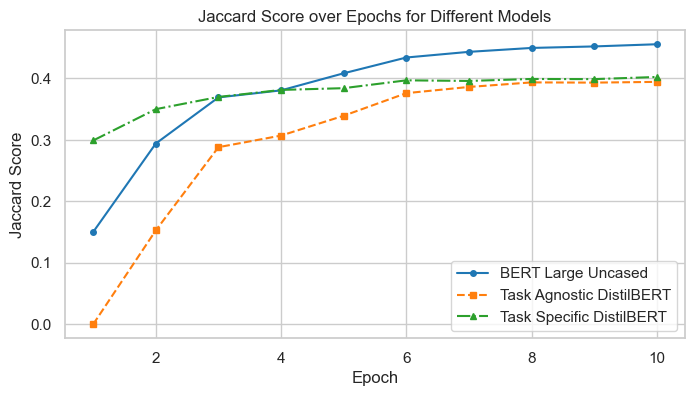

In [33]:
import matplotlib.pyplot as plt

# Assuming that your epochs start from 0 and increase by 2
epochs = range(1,11)

# Jaccard scores for each model (replace with your values)
bert_jaccard = [0.150144, 0.294118, 0.369182, 0.380621, 0.408421, 0.434089, 0.443303, 0.449669, 0.452132, 0.455674]
agnostic_distilbert_jaccard = [0.000000, 0.152741, 0.288169, 0.307022, 0.339322, 0.376086, 0.386175, 0.393603, 0.393224, 0.394441]
specific_distilbert_jaccard = [0.299056, 0.350035, 0.369896, 0.381340, 0.384203, 0.396954, 0.395952, 0.399185, 0.398923, 0.402424]

# F1 scores for BERT Large Uncased
bert_f1 = [0.261087, 0.454545, 0.539274, 0.551376, 0.579970, 0.605386, 0.614290, 0.620375, 0.622715, 0.626066]
# F1 scores for Task Agnostic DistilBERT
agnostic_distilbert_f1 = [0.000000, 0.265005, 0.447409, 0.469803, 0.506707, 0.546603, 0.557181, 0.564871, 0.564481, 0.565733]
# F1 scores for Task Specific DistilBERT
specific_distilbert_f1 = [0.460421, 0.518557, 0.540035, 0.552130, 0.555126, 0.568314, 0.567286, 0.570596, 0.570329, 0.573898]


plt.figure(figsize=(8, 4))
plt.plot(epochs, bert_jaccard, marker='o', markersize=4, linestyle='-', label='BERT Large Uncased')
plt.plot(epochs, agnostic_distilbert_jaccard, marker='s', markersize=4, linestyle='--', label='Task Agnostic DistilBERT')
plt.plot(epochs, specific_distilbert_jaccard, marker='^', markersize=4, linestyle='-.', label='Task Specific DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Jaccard Score')
plt.title('Jaccard Score over Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()


# 4. 모델 사용하기

## 4.1 모델 비교하기

In [34]:
# Our base model
trained_model = AutoModelForSequenceClassification.from_pretrained(
    f"genre-prediction-bert", problem_type="multi_label_classification",
)

In [35]:
# Our task specific model
task_specific_model = AutoModelForSequenceClassification.from_pretrained(
    'distilled-genre-prediction',problem_type="multi_label_classification", 
)

In [36]:
batch = data_collator(list(description_encoded_dataset['test'])[:16])

In [37]:
%timeit trained_model(**batch)

4.77 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
distil_batch = {k: v for k, v in batch.items() if k != 'token_type_ids'}

In [39]:
%timeit task_specific_model(**distil_batch)

439 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
# ^^ 증류 모델이 6배 이상 빠르다는 것을 보여줍니다.

In [41]:
# 훈련된 모델의 파라미터 개수 계산하기
num_params_trained = sum(p.numel() for p in trained_model.parameters())
print(f'Trained Model has {num_params_trained} parameters.')

# 훈련된 모델에 있는 파라미터의 데이터 유형을 인쇄합니다.
for p in trained_model.parameters():
    print(f'Data type of the parameter in trained_model: {p.dtype}')
    break  # 모든 매개 변수의 dtype이 같다고 가정하고 첫 번째 매개 변수를 인쇄한 후 중단합니다.

# task_specific_model의 파라미터 개수를 계산합니다.
num_params_task_specific = sum(p.numel() for p in task_specific_model.parameters())
print(f'Task Specific Model has {num_params_task_specific} parameters.')

# 작업별 모델에 있는 파라미터의 데이터 타입을 인쇄합니다.
for p in task_specific_model.parameters():
    print(f'Data type of the parameter in task_specific_model: {p.dtype}')
    break   # 모든 매개변수의 dtype이 같다고 가정하고 첫 번째 매개변수를 출력한 후 중단합니다.

# 메모리 사용량을 추정합니다(매개변수가 32비트 부동 소수점으로 저장된다고 가정할 때 MB 단위).
memory_usage_trained = num_params_trained * 4 / (1024 ** 2)
memory_usage_task_specific = num_params_task_specific * 4 / (1024 ** 2)

print(f'Estimated memory for trained_model: {memory_usage_trained} MB')
print(f'Estimated memory for task_specific_model: {memory_usage_task_specific} MB')

Trained Model has 335184938 parameters.
Data type of the parameter in trained_model: torch.float32
Task Specific Model has 66985770 parameters.
Data type of the parameter in task_specific_model: torch.float32
Estimated memory for trained_model: 1278.6290664672852 MB
Estimated memory for task_specific_model: 255.53043365478516 MB


## 4.2 자카드 점수 비교

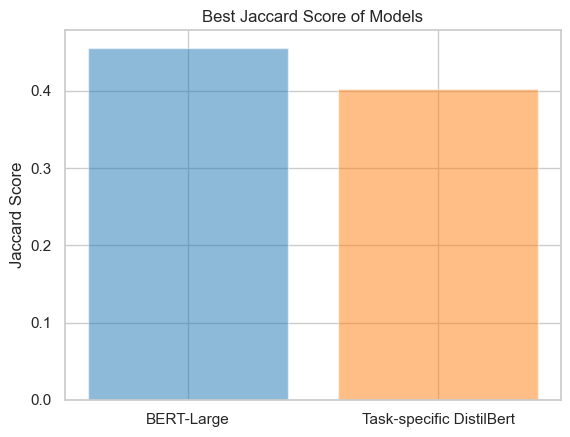

In [42]:
models = ['BERT-Large', 'Task-specific DistilBert']

# Estimated memory usage (in MB)
memory_usage = [.455674, 0.402424]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, memory_usage, align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Jaccard Score')
ax.set_title('Best Jaccard Score of Models')

# Display the plot
plt.show()

## 4.3 메모리 사용량 비교

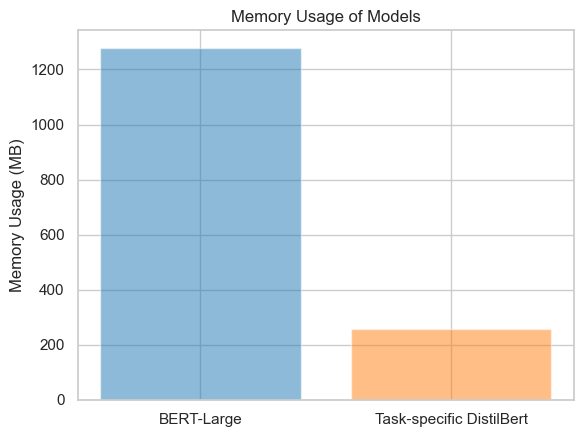

In [43]:
# Model names
models = ['BERT-Large', 'Task-specific DistilBert']

# Estimated memory usage (in MB)
memory_usage = [1278.63, 255.53]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, memory_usage, align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage of Models')

# Display the plot
plt.show()

## 4.4 소요 시간 비교

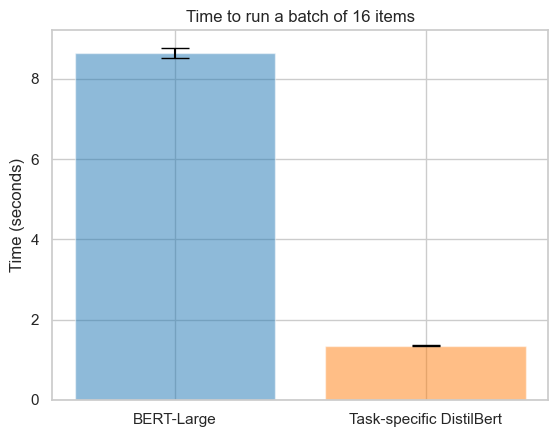

In [44]:
# Model names
models = ['BERT-Large', 'Task-specific DistilBert']

# Times taken to run a batch of 16 items (in seconds)
times = [8.65, 1.35]

# Standard deviations
std_devs = [0.121, 0.017]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot
ax.bar(models, times, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10,  color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Time (seconds)')
ax.set_title('Time to run a batch of 16 items')

# Display the plot
plt.show()

$$p_i = \frac{e^{z_i/T}}{\sum_{j=1}^N e^{z_j/T}}$$